In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import GPy
from BNN_Dropout import NN_Dropout, BNN_Dropout
from BNN_SGDHMC import BNN_SGDHMC
from Benchmark import RandomNN
from pybnn.bohamiann import Bohamiann

plt.rcParams['figure.figsize'] = (12.0, 8)


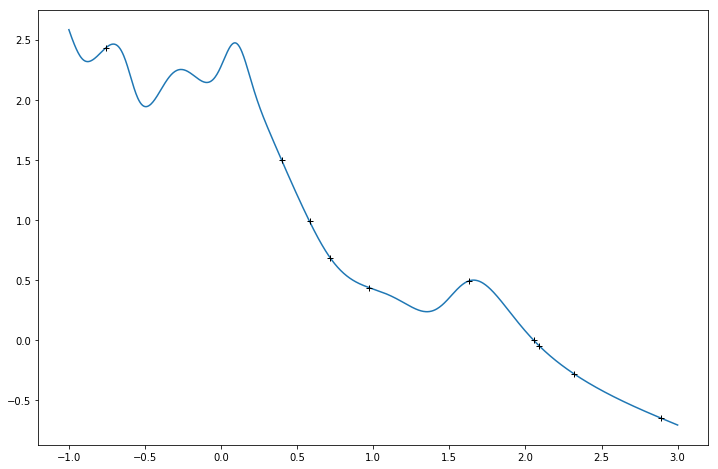

In [92]:
bench = RandomNN(1,3,50,nn.Tanh())
bench.rand_normal_weight(0.6)
num_plot  = 1000
num_train = 10
x = torch.linspace(-1,3,num_plot)[:,None]
y = bench(x)
train_id = np.random.permutation(num_plot)[:num_train]
train_x = x[train_id]
train_y = y[train_id]
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')

In [93]:
conf = dict()
conf['num_epochs'] = 1600
conf['num_hidden'] = 50
conf['num_layers'] = 3
conf['batch_size'] = 128


conf['dropout_rate'] = 0.01
conf['lr']           = 0.1
conf['tau']          = 1.5 #0.15
conf['lscale']       = 0.25


model = BNN_Dropout(1,nn.Tanh(), conf)

conf_hmc = dict()
hmc_model = BNN_SGDHMC(dim = 1, act = nn.Tanh(), conf = conf_hmc)
kern = GPy.kern.RBF(input_dim = 1)
gp = GPy.models.GPRegression(X=train_x.numpy(), Y= train_y.detach().numpy(), kernel=kern)
gp.likelihood.variance = 1e-2

In [94]:
hmc_model.train(train_x, train_y)
model.train(train_x, train_y)
gp.optimize()

Step      100 : NLL =  1.1362e+03 MSE = 1.4873e+00 Time =  1.05
Step      200 : NLL =  1.4019e+03 MSE = 1.4723e+00 Time =  2.08
Step      300 : NLL =  1.6983e+03 MSE = 1.4625e+00 Time =  3.09
Step      400 : NLL =  2.1028e+03 MSE = 1.4949e+00 Time =  4.07
Step      500 : NLL =  2.5756e+03 MSE = 1.4825e+00 Time =  5.06
Step      600 : NLL =  3.1733e+03 MSE = 1.5054e+00 Time =  6.06
Step      700 : NLL =  3.8203e+03 MSE = 1.4895e+00 Time =  7.07
Step      800 : NLL =  4.5542e+03 MSE = 1.5019e+00 Time =  8.08
Step      900 : NLL =  5.5134e+03 MSE = 1.5121e+00 Time =  9.08
Step     1000 : NLL =  6.5173e+03 MSE = 1.5053e+00 Time = 10.09
Step     1100 : NLL =  7.8949e+03 MSE = 1.4873e+00 Time = 11.10
Step     1200 : NLL =  1.0067e+04 MSE = 1.5182e+00 Time = 12.11
Step     1300 : NLL =  1.2370e+04 MSE = 1.4984e+00 Time = 13.11
Step     1400 : NLL =  1.5157e+04 MSE = 1.5007e+00 Time = 14.12
Step     1500 : NLL =  1.8512e+04 MSE = 1.5068e+00 Time = 15.11
Step     1600 : NLL =  2.1910e+04 MSE = 

 /mnt/c/code/pybnn/pybnn/bohamiann.py:119: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step     2100 : NLL =  5.8832e+04 MSE = 1.4826e+00 Samples= 1 Time = 20.95
Step     2200 : NLL =  1.6675e+03 MSE = 1.4896e+00 Samples= 3 Time = 21.81
Step     2300 : NLL =  1.6691e+03 MSE = 1.4849e+00 Samples= 5 Time = 22.71
Step     2400 : NLL =  1.9241e+03 MSE = 1.4863e+00 Samples= 7 Time = 23.58
Step     2500 : NLL =  2.2341e+03 MSE = 1.4887e+00 Samples= 9 Time = 24.42
Step     2600 : NLL =  2.5455e+03 MSE = 1.4899e+00 Samples= 11 Time = 25.36
Step     2700 : NLL =  2.8844e+03 MSE = 1.4910e+00 Samples= 13 Time = 26.27
Step     2800 : NLL =  3.2411e+03 MSE = 1.4922e+00 Samples= 15 Time = 27.06
Step     2900 : NLL =  3.5379e+03 MSE = 1.4927e+00 Samples= 17 Time = 27.88
Step     3000 : NLL =  3.7729e+03 MSE = 1.4933e+00 Samples= 19 Time = 28.73
Step     3100 : NLL =  3.9987e+03 MSE = 1.4944e+00 Samples= 21 Time = 29.59
Step     3200 : NLL =  4.2588e+03 MSE = 1.4951e+00 Samples= 23 Time = 30.43
Step     3300 : NLL =  7.6064e+01 MSE = 1.4551e+00 Samples= 25 Time = 31.29
Step     3400 : N

Text(0.5,1,'Gaussian process')

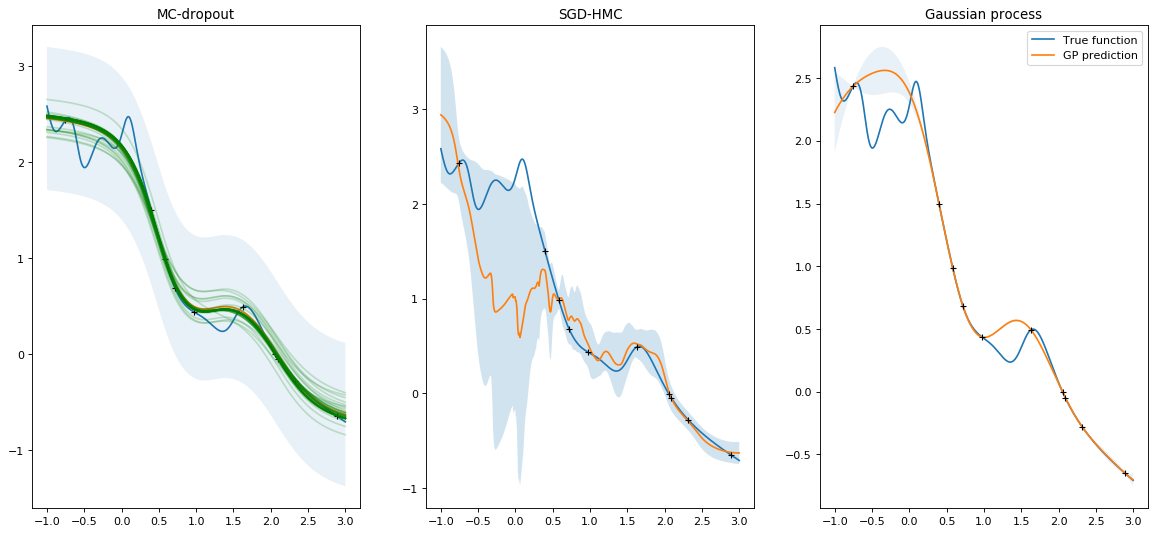

In [97]:
#py = model.predict(x)
py,pv = model.predict_mv(x)
ps = torch.sqrt(pv)
m_hmc,v_hmc = hmc_model.predict_mv(x)
m_hmc = m_hmc.detach().numpy().reshape(num_plot)
s_hmc   = v_hmc.sqrt().detach().numpy().reshape(num_plot)
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')


plt.subplot(131)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(),py.detach().numpy(),label = 'Pred')
plt.fill_between(
    x.numpy().reshape(num_plot), 
    (py - ps).reshape(num_plot).detach().numpy(), 
    (py + ps).reshape(num_plot).detach().numpy(), alpha = 0.1)
for i in range(50):
    net = model.sample()
    py  = net((x - model.x_mean) / model.x_std) * model.y_std + model.y_mean
    plt.plot(x.numpy(),py.detach().numpy(), 'g', alpha = 0.2)
plt.title('MC-dropout')

plt.subplot(132)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(x.numpy(), m_hmc)
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), m_hmc + s_hmc, m_hmc - s_hmc, alpha = 0.2)
plt.title('SGD-HMC')

plt.subplot(133)
gp_m, gp_v = gp.predict(x.numpy())
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')
plt.plot(x.numpy(), gp_m, label = 'GP prediction')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), (gp_m - np.sqrt(gp_v)).reshape(num_plot), (gp_m + np.sqrt(gp_v)).reshape(num_plot), alpha = 0.1)
plt.legend()
plt.title('Gaussian process')

In [83]:
np.sqrt(1/0.15)

2.581988897471611